In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
from matplotlib.lines import Line2D
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

In [2]:
with open("simu6a_data/simu6a_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)
# df_study = df_study.loc[df_study.session < 500]
# df_test = df_test.loc[df_test.session < 500]

In [3]:
df_study

,study_itemno1,study_itemno2,study_item1,study_item2,list,session
0,1569,1107,VINEGAR,PORCUPINE,0,0
1,30,696,APARTMENT,HEADBAND,0,0
2,1457,1443,THIGH,TECHNICIAN,0,0
3,1331,31,SNACK,APE,0,0
4,1377,1579,STEP,WAIST,0,0
...,...,...,...,...,...,...
251995,842,1335,LOLLIPOP,SNOB,41,999
251996,260,57,CATHEDRAL,ATTIRE,41,999
251997,946,1306,NET,SIGNATURE,41,999
251998,164,981,BRACES,ORCHESTRA,41,999


In [4]:
df_test

,test_itemno,test_item,correct_ans,lag,list,session,order
0,468,DINNER,681,0,0,0,2
1,1579,WAIST,1377,2,0,0,2
2,1331,SNACK,31,4,0,0,1
3,1457,THIGH,1443,6,0,0,1
4,696,HEADBAND,30,8,0,0,2
...,...,...,...,...,...,...,...
251995,981,ORCHESTRA,164,2,41,999,2
251996,946,NET,1306,4,41,999,1
251997,57,ATTIRE,260,6,41,999,2
251998,842,LOLLIPOP,1335,8,41,999,1


### Run CMR-IA

In [5]:
s_mat = np.load('../../Data/wordpools/ltp_FR_similarity_matrix.npy')

In [6]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.7,
    beta_cue = 0.4,
    beta_distract = 0.01,
    beta_rec_post = 0.99,
    beta_rec = 0.5,
    gamma_fc = 0.2,
    gamma_cf = 0.2,
    s_fc = 0.1,
    s_cf = 0.1,
    c_thresh = 0.01,
    kappa = 0.04,
    lamb = 0.02,
    eta = 0.01,
    alpha = 0.9,
    omega = 3,
    phi_s = 1,
    phi_d = 1.3,
    nitems_in_accumulator = 48,
    d_ass = 0.8
)
params

# using parameters from simu5, the figure gives a U shape, because of U shape f_in diff, because primacy
# prob: how to flatten end? how to make initial decrease straight?
# 7.17 phi_s, phi_d could only flatten the last three
# phi_s control the base level and the last node
# phi_d control the last two

{'beta_enc': 0.7,
 'beta_rec': 0.5,
 'beta_cue': 0.4,
 'beta_rec_post': 0.99,
 'beta_distract': 0.01,
 'phi_s': 1,
 'phi_d': 1.3,
 's_cf': 0.1,
 's_fc': 0.1,
 'kappa': 0.04,
 'eta': 0.01,
 'omega': 3,
 'alpha': 0.9,
 'c_thresh': 0.01,
 'c_thresh_itm': 0.5,
 'c_thresh_ass': 0.5,
 'd_ass': 0.8,
 'lamb': 0.02,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 48,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 20,
 'm': 0,
 'n': 1,
 'c1': 0,
 'thresh_sigma': 0,
 'No_recall': None,
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.2,
 'gamma_cf': 0.2}

In [7]:
df_simu, f_in, f_dif = cmr.run_norm_cr_multi_sess(params,df_study, df_test ,s_mat)
df_simu

CMR2 Time: 1103.0578334331512


,list,session,test_itemno,s_resp,s_rt,csim
0,0,0,468,681.0,1960.0,0.740644
1,0,0,1579,1377.0,4260.0,0.452023
2,0,0,1331,31.0,4810.0,0.482524
3,0,0,1457,-1.0,-1.0,-1.000000
4,0,0,696,-1.0,-1.0,-1.000000
...,...,...,...,...,...,...
251995,41,999,981,-1.0,-1.0,-1.000000
251996,41,999,946,-1.0,-1.0,-1.000000
251997,41,999,57,-1.0,-1.0,-1.000000
251998,41,999,842,-1.0,-1.0,-1.000000


In [8]:
df_simu = df_simu.merge(df_test,on=['session','list','test_itemno'])
df_simu['correct'] = df_simu.s_resp == df_simu.correct_ans
df_simu

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,order,correct
0,0,0,468,681.0,1960.0,0.740644,DINNER,681,0,2,True
1,0,0,1579,1377.0,4260.0,0.452023,WAIST,1377,2,2,True
2,0,0,1331,31.0,4810.0,0.482524,SNACK,31,4,1,True
3,0,0,1457,-1.0,-1.0,-1.000000,THIGH,1443,6,1,False
4,0,0,696,-1.0,-1.0,-1.000000,HEADBAND,30,8,2,False
...,...,...,...,...,...,...,...,...,...,...,...
251995,41,999,981,-1.0,-1.0,-1.000000,ORCHESTRA,164,2,2,False
251996,41,999,946,-1.0,-1.0,-1.000000,NET,1306,4,1,False
251997,41,999,57,-1.0,-1.0,-1.000000,ATTIRE,260,6,2,False
251998,41,999,842,-1.0,-1.0,-1.000000,LOLLIPOP,1335,8,1,False


In [9]:
sessions = np.unique(df_simu.session)
for sess in sessions:
    df_tmp = df_study.loc[df_study.session == sess]
    tmp1 = df_tmp.study_itemno1.to_numpy()
    tmp2 = df_tmp.study_itemno2.to_numpy()
    tmp = np.concatenate((tmp1, tmp2))
    tmp = np.sort(tmp)
    tmp_test = df_simu.loc[df_study.session == sess,"test_itemno"]
    tmp_corr = df_simu.loc[df_study.session == sess,"correct_ans"]
    testid = np.searchsorted(tmp, tmp_test)
    corrid = np.searchsorted(tmp, tmp_corr)

    df_simu.loc[df_simu.session == sess, 'corr_fin']= [f_dif[sess][i][id] for i, id in enumerate(corrid)]
    # df_simu.loc[df_simu.session == sess, 'omean_fin'] = [np.mean(np.delete(f_dif[sess][i], id)) for i, id in corrid]
    df_simu.loc[df_simu.session == sess, 'omax_fin'] = [np.max(np.delete(f_dif[sess][i], id)) for i, id in enumerate(corrid)]
df_simu

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,order,correct,corr_fin,omax_fin
0,0,0,468,681.0,1960.0,0.740644,DINNER,681,0,2,True,-0.306193,-0.535682
1,0,0,1579,1377.0,4260.0,0.452023,WAIST,1377,2,2,True,-0.608153,-0.632742
2,0,0,1331,31.0,4810.0,0.482524,SNACK,31,4,1,True,-0.556623,-0.673737
3,0,0,1457,-1.0,-1.0,-1.000000,THIGH,1443,6,1,False,-0.617644,-0.651712
4,0,0,696,-1.0,-1.0,-1.000000,HEADBAND,30,8,2,False,-0.589189,-0.614797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,41,999,981,-1.0,-1.0,-1.000000,ORCHESTRA,164,2,2,False,-0.545441,-0.706784
251996,41,999,946,-1.0,-1.0,-1.000000,NET,1306,4,1,False,-0.607595,-0.550031
251997,41,999,57,-1.0,-1.0,-1.000000,ATTIRE,260,6,2,False,-0.584671,-0.565718
251998,41,999,842,-1.0,-1.0,-1.000000,LOLLIPOP,1335,8,1,False,-0.600924,-0.578693


In [10]:
# clean first 2 list
df_simu = df_simu.query("list > 1")
df_simu

,list,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,order,correct,corr_fin,omax_fin
12,2,0,887,816.0,2110.0,0.705167,MERMAID,816,0,1,True,-0.370826,-0.518714
13,2,0,10,1101.0,3230.0,0.531313,AGENT,1101,2,1,True,-0.508232,-0.669455
14,2,0,1411,-1.0,-1.0,-1.000000,SUPPER,1561,4,2,False,-0.645636,-0.643379
15,2,0,959,1104.0,3890.0,0.501592,NOTEBOOK,1104,6,2,True,-0.529550,-0.642220
16,2,0,1448,-1.0,-1.0,-1.000000,TEMPLE,969,8,2,False,-0.569871,-0.688449
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,41,999,981,-1.0,-1.0,-1.000000,ORCHESTRA,164,2,2,False,-0.545441,-0.706784
251996,41,999,946,-1.0,-1.0,-1.000000,NET,1306,4,1,False,-0.607595,-0.550031
251997,41,999,57,-1.0,-1.0,-1.000000,ATTIRE,260,6,2,False,-0.584671,-0.565718
251998,41,999,842,-1.0,-1.0,-1.000000,LOLLIPOP,1335,8,1,False,-0.600924,-0.578693


In [17]:
df_simu.to_pickle("simu6a_data/simu6a_result.pkl")

### PLOT

In [18]:
with open("simu6a_data/simu6a_result.pkl", 'rb') as inp:
    df_simu = pickle.load(inp)

In [ ]:
df_fin = df_simu.groupby('lag')[['corr_fin','omax_fin']].mean().reset_index()
df_fin['dif'] = df_fin['corr_fin'] - df_fin['omax_fin']
df_fin

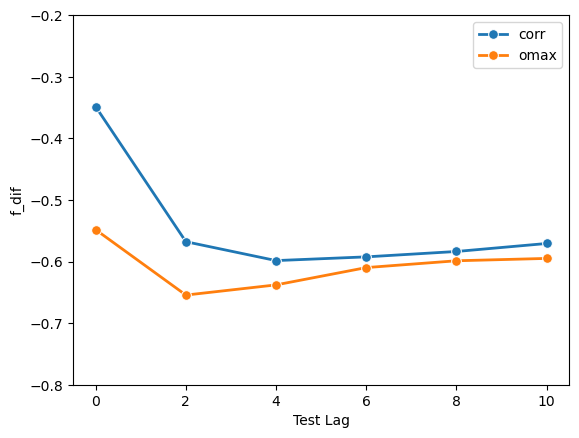

In [12]:
sns.lineplot(data=df_fin, x='lag', y='corr_fin', linewidth=2, marker='o', markersize = 7, label='corr')
# sns.lineplot(data=df_fin, x='lag', y='omean_fin', linewidth=2, marker='o', markersize = 7)
sns.lineplot(data=df_fin, x='lag', y='omax_fin', linewidth=2, marker='o', markersize = 7, label='omax')
plt.ylim([-0.8,-0.2])
plt.xlabel('Test Lag')
plt.ylabel('f_dif')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

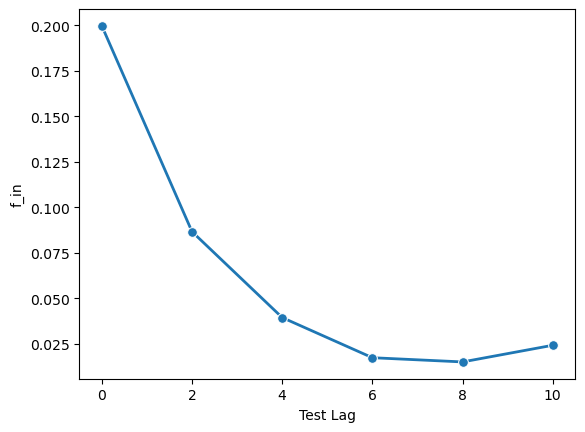

In [13]:
sns.lineplot(data=df_fin, x='lag', y='dif', linewidth=2, marker='o', markersize = 7)
# plt.ylim([0,1])
plt.xlabel('Test Lag')
plt.ylabel('f_in')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

In [14]:
df_laggp = df_simu.groupby(['lag','order']).correct.mean().to_frame(name='corr_rate').reset_index()
df_laggp

,lag,order,corr_rate
0,0,1,0.977298
1,0,2,0.976554
2,2,1,0.695144
3,2,2,0.695957
4,4,1,0.397801
5,4,2,0.390645
6,6,1,0.272455
7,6,2,0.270942
8,8,1,0.246697
9,8,2,0.247305


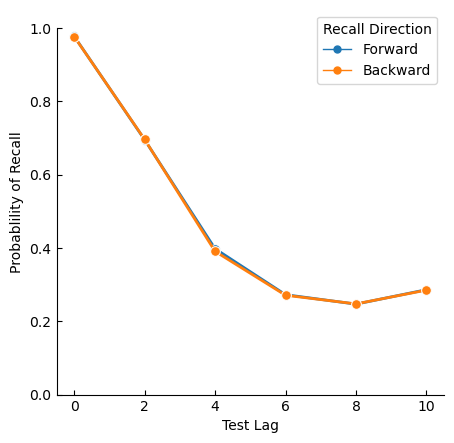

In [15]:
fig, ax = plt.subplots(figsize=(6,4.5))
fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

fig,ax = plt.subplots(figsize=(5,5))
ax.spines['left'].set_bounds(0, 1)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_laggp, x='lag', y='corr_rate', linewidth=2, marker='o', markersize = 10, hue='order',palette='tab10')
plt.ylim([0,1.05])
plt.xlabel('Test Lag')
plt.ylabel('Probablility of Recall')
ax.set(xlabel=None, ylabel=None)
plt.tick_params(labelleft=False)
legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o',
                          markersize = 10, linestyle='-',label = 'Forward'),
                   Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o',
                          markersize = 10, linestyle='-', label = 'Backward')]
L = plt.legend(handles = legend_elements, title='Recall Direction',loc='upper right')

plt.savefig('simu6a_fig/simu6a_recall.pdf')
plt.show()